In [12]:

import warnings
warnings.filterwarnings('ignore')

# Set display options for better output viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load a dataset
df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")

# Show top rows
df.head()





,customer_id,service_date,vehicle_type,service_type,service_cost,service_duration,customer_rating,location,payment_method,visit_frequency,total_spent,avg_spent_per_visit,avg_rating,days_since_last_visit,service_year,service_month,day_of_week,is_weekend,vehicle_type_encoded,service_type_encoded,day_of_week_encoded,location_encoded,payment_method_encoded,cost_category,loyalty_tier,recency_category
0,C0440,2024-02-25,Luxury,Interior Detailing,1.000000,0.485714,6.0,Suburban,Credit Card,0.076923,0.225571,0.826358,4.00,0.424691,2024,2,Sunday,True,2,10,3,4,1,Premium,New,Warming
1,C0603,2022-02-18,Truck,Deluxe Wash,0.497168,0.323810,3.0,Highway,Debit Card,0.153846,0.135586,0.328881,2.67,0.821235,2022,2,Friday,False,11,8,0,2,2,Standard,New,At-Risk
2,C0230,2022-09-26,Unknown,Premium Wash,0.406672,0.152381,4.0,Highway,Mobile Pay,0.384615,0.214649,0.257584,2.83,0.245926,2022,9,Monday,False,14,12,1,2,4,Standard,Regular,Active
3,C0050,2021-05-22,Unknown,Basic Wash,0.366268,0.076190,4.0,Airport,Debit Card,0.307692,0.245665,0.355892,3.60,0.866173,2021,5,Saturday,True,14,7,2,0,2,Standard,Regular,At-Risk
4,C0646,2021-08-12,Van,Deluxe Wash,0.474093,0.314286,3.0,Highway,Mobile Pay,0.384615,0.217104,0.260552,4.50,0.671111,2021,8,Thursday,False,15,8,4,2,4,Standard,Regular,At-Risk


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# Load a dataset (example)
df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")


# Select features for prediction
features = [
    'vehicle_type_encoded',
    'service_type_encoded',
    'day_of_week_encoded',
    'location_encoded',
    'payment_method_encoded',
    'service_duration',
    'customer_rating',
    'visit_frequency',
    'total_spent',
    'avg_spent_per_visit',
    'avg_rating',
    'days_since_last_visit',
]

target = 'service_cost'

# Prepare X and y
X = df[features]
y = df[target]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor (handles nonlinearities well)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.3f}")

# Predict on a single sample (first test row)
sample_features = X_test.iloc[0].values.reshape(1, -1)
predicted_cost = model.predict(sample_features)[0]
actual_cost = y_test.iloc[0]

print(f"Predicted service cost: {predicted_cost:.3f}")
print(f"Actual service cost: {actual_cost:.3f}")


Mean Absolute Error: 0.039
Predicted service cost: 0.360
Actual service cost: 0.354



✅ Features used: ['visit_frequency', 'total_spent', 'avg_spent_per_visit', 'avg_rating', 'days_since_last_visit', 'service_duration', 'service_cost', 'is_weekend', 'service_month', 'vehicle_type_encoded', 'service_type_encoded', 'location_encoded', 'payment_method_encoded']

📊 Performance Metrics:
   • MAE  = 57.74 days
   • RMSE = 81.62 days
   • R²   = 0.000


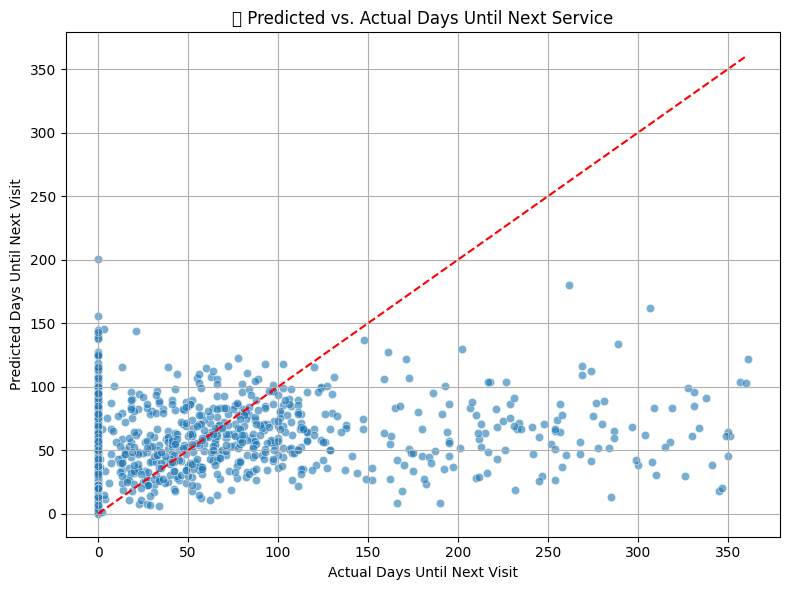


🔍 Sample predictions:
      Actual Days  Predicted Days
3306         64.0            83.1
2942          0.0            38.2
5148         80.0            79.8
4978         66.0            76.1
6154         34.0             5.8
2691         68.0            48.4
2409          0.0            95.3
173           0.0            75.8
5678         83.0            46.1
2045         81.0            82.7


In [20]:


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# ===== Task 1: Predict Next Service Date =====

def prepare_next_service_dataset(df):
    """
    Add 'days_until_next_visit' as the prediction target for each customer.
    """
    df = df.copy()

    # Sort by customer and date
    df['service_date'] = pd.to_datetime(df['service_date'])  # Ensure datetime
    df = df.sort_values(by=['customer_id', 'service_date'])

    # Calculate target: days until next visit
    df['next_service_date'] = df.groupby('customer_id')['service_date'].shift(-1)
    df['days_until_next_visit'] = (df['next_service_date'] - df['service_date']).dt.days

    # Drop rows without next visit
    df = df.dropna(subset=['days_until_next_visit'])

    # Only keep reasonable targets (e.g., < 365 days)
    df = df[df['days_until_next_visit'] <= 365]

    return df


def train_next_service_model(df):
    """
    Train and evaluate a model to predict the number of days until a customer's next visit.
    """

    # Step 1: Prepare data
    df = prepare_next_service_dataset(df)

    # Step 2: Define features and target
    features = [
        'visit_frequency', 'total_spent', 'avg_spent_per_visit',
        'avg_rating', 'days_since_last_visit', 'service_duration',
        'service_cost', 'is_weekend', 'service_month',

        # Encoded features
        'vehicle_type_encoded', 'service_type_encoded', 'location_encoded', 'payment_method_encoded'
    ]

    available_features = [f for f in features if f in df.columns]
    print(f"\n✅ Features used: {available_features}")

    X = df[available_features]
    y = df['days_until_next_visit']

    # Step 3: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 4: Train model
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train, y_train)

    # Step 5: Predict
    preds = model.predict(X_test)

    # Step 6: Evaluate
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print("\n📊 Performance Metrics:")
    print(f"   • MAE  = {mae:.2f} days")
    print(f"   • RMSE = {rmse:.2f} days")
    print(f"   • R²   = {r2:.3f}")

    # Step 7: Visualize predictions
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=preds, alpha=0.6)
    plt.xlabel("Actual Days Until Next Visit")
    plt.ylabel("Predicted Days Until Next Visit")
    plt.title("🧠 Predicted vs. Actual Days Until Next Service")
    plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # Diagonal line
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Preview some predictions
    comparison_df = X_test.copy()
    comparison_df['Actual Days'] = y_test
    comparison_df['Predicted Days'] = preds
    print("\n🔍 Sample predictions:")
    print(comparison_df[['Actual Days', 'Predicted Days']].head(10).round(1))

    return model, comparison_df


# Run this as your task function
if __name__ == "__main__":
    # Load preprocessed dataset (from your pipeline)
    df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")

    # Run Task 1
    model_rf, predictions_df = train_next_service_model(df)


📊 XGBoost Performance Metrics:
   • MAE  = 57.87 days
   • RMSE = 80.55 days
   • R²   = 0.026


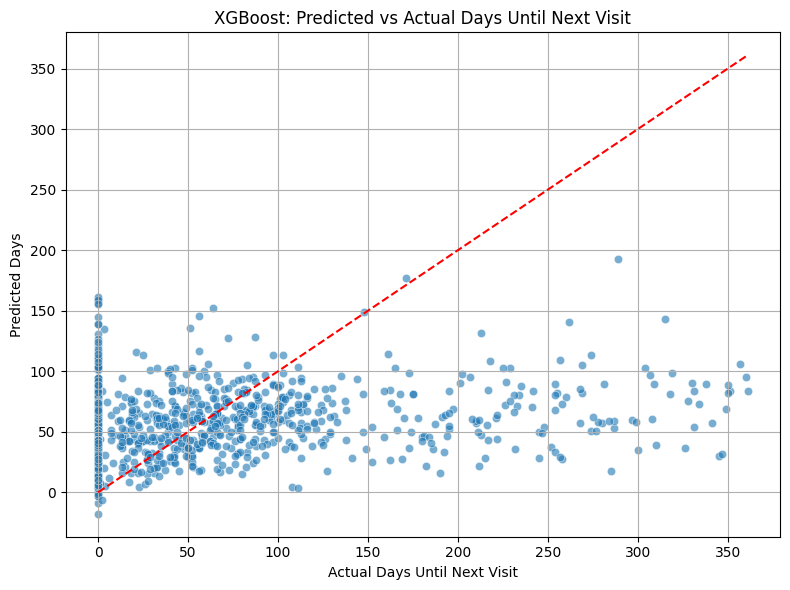


🔍 Sample predictions:
      Actual Days  Predicted Days
3306         64.0       45.400002
2942          0.0       25.299999
5148         80.0       15.500000
4978         66.0       65.500000
6154         34.0       42.000000
2691         68.0       58.200001
2409          0.0       73.900002
173           0.0       52.099998
5678         83.0       84.300003
2045         81.0       82.300003


In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_next_service_dataset(df):
    df = df.copy()
    df['service_date'] = pd.to_datetime(df['service_date'])
    df = df.sort_values(by=['customer_id', 'service_date'])
    
    df['next_service_date'] = df.groupby('customer_id')['service_date'].shift(-1)
    df['days_until_next_visit'] = (df['next_service_date'] - df['service_date']).dt.days
    df = df.dropna(subset=['days_until_next_visit'])
    df = df[df['days_until_next_visit'] <= 365]
    
    return df


def train_xgb_next_service_model(df):
    # Data prep
    df = prepare_next_service_dataset(df)

    # Features for modeling
    features = [
        'visit_frequency', 'total_spent', 'avg_spent_per_visit',
        'avg_rating', 'days_since_last_visit', 'service_duration',
        'service_cost', 'is_weekend', 'service_month',
        'vehicle_type_encoded', 'service_type_encoded', 'location_encoded', 'payment_method_encoded'
    ]
    features = [f for f in features if f in df.columns]

    X = df[features]
    y = df['days_until_next_visit']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGB Regressor
    model = XGBRegressor(n_estimators=200, learning_rate=0.07, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print("\n📊 XGBoost Performance Metrics:")
    print(f"   • MAE  = {mae:.2f} days")
    print(f"   • RMSE = {rmse:.2f} days")
    print(f"   • R²   = {r2:.3f}")

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=preds, alpha=0.6)
    plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Days Until Next Visit")
    plt.ylabel("Predicted Days")
    plt.title("XGBoost: Predicted vs Actual Days Until Next Visit")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Show samples
    result = X_test.copy()
    result['Actual Days'] = y_test
    result['Predicted Days'] = preds
    print("\n🔍 Sample predictions:")
    print(result[['Actual Days', 'Predicted Days']].head(10).round(1))

    return model, result


# Run
if __name__ == "__main__":
    df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")
    xgb_model, xgb_predictions = train_xgb_next_service_model(df)


🌲 Training Random Forest Classifier...

📋 Evaluation for Random Forest:
Accuracy : 0.4501953125
Precision: 0.41962275493999757
Recall   : 0.4501953125
F1-score : 0.41425696602814555

🔍 Classification Report:
              precision    recall  f1-score   support

        Soon       0.32      0.16      0.21       241
       Later       0.39      0.24      0.30       289
     Dormant       0.49      0.71      0.58       494

    accuracy                           0.45      1024
   macro avg       0.40      0.37      0.36      1024
weighted avg       0.42      0.45      0.41      1024



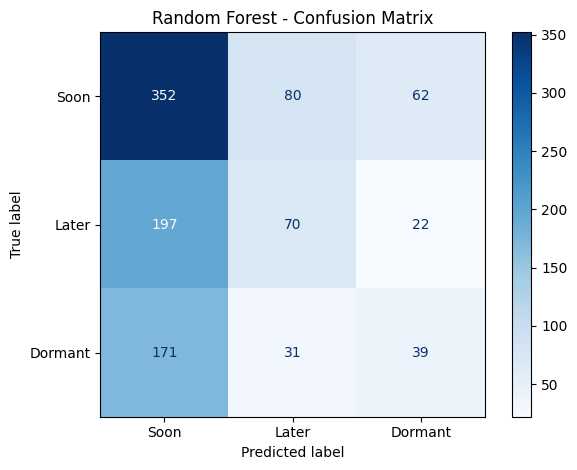


📈 Training Logistic Regression...

📋 Evaluation for Logistic Regression:
Accuracy : 0.435546875
Precision: 0.45246484667845366
Recall   : 0.435546875
F1-score : 0.441656768334501

🔍 Classification Report:
              precision    recall  f1-score   support

        Soon       0.30      0.37      0.33       241
       Later       0.39      0.41      0.40       289
     Dormant       0.57      0.49      0.52       494

    accuracy                           0.44      1024
   macro avg       0.42      0.42      0.42      1024
weighted avg       0.45      0.44      0.44      1024



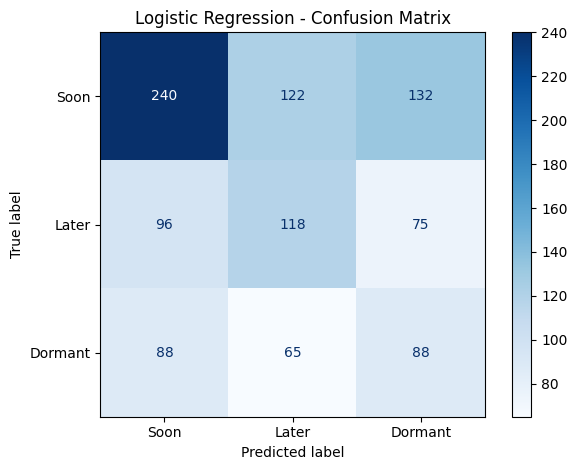


📊 Sample predictions with probability of returning 'Soon':
     Actual Class RF_Predicted Class  RF_Soon_Prob LR_Predicted Class  LR_Soon_Prob
1117         Soon              Later         0.380               Soon         0.408
6420        Later               Soon         0.735            Dormant         0.383
2196         Soon              Later         0.200            Dormant         0.211
4559         Soon               Soon         0.487               Soon         0.449
5666         Soon               Soon         0.853               Soon         0.471
1475      Dormant               Soon         0.513              Later         0.328
2894         Soon               Soon         0.580              Later         0.247
3091        Later               Soon         0.587               Soon         0.479
4979      Dormant               Soon         0.713            Dormant         0.378
5127         Soon               Soon         0.720               Soon         0.396


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

def prepare_classification_dataset(df):
    df = df.copy()
    df['service_date'] = pd.to_datetime(df['service_date'])
    df = df.sort_values(by=['customer_id', 'service_date'])
    df['next_service_date'] = df.groupby('customer_id')['service_date'].shift(-1)
    df['days_until_next_visit'] = (df['next_service_date'] - df['service_date']).dt.days
    df = df.dropna(subset=['days_until_next_visit'])
    df = df[df['days_until_next_visit'] <= 365]

    def classify_days(days):
        if days <= 30:
            return 'Soon'
        elif days <= 90:
            return 'Later'
        else:
            return 'Dormant'

    df['visit_class'] = df['days_until_next_visit'].apply(classify_days)
    return df


def evaluate_classification_model(model, X_test, y_test, labels, model_name="Model"):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    print(f"\n📋 Evaluation for {model_name}:")
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='weighted'))
    print("Recall   :", recall_score(y_test, preds, average='weighted'))
    print("F1-score :", f1_score(y_test, preds, average='weighted'))

    print("\n🔍 Classification Report:")
    print(classification_report(y_test, preds, target_names=labels))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return preds, probs


def train_visit_classifiers(df):
    df = prepare_classification_dataset(df)

    features = [
        'visit_frequency', 'total_spent', 'avg_spent_per_visit',
        'avg_rating', 'days_since_last_visit', 'service_duration',
        'service_cost', 'is_weekend', 'service_month',
        'vehicle_type_encoded', 'service_type_encoded',
        'location_encoded', 'payment_method_encoded'
    ]
    features = [f for f in features if f in df.columns]

    X = df[features]
    y = df['visit_class']
    labels = ['Soon', 'Later', 'Dormant']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Random Forest Classifier
    print("\n🌲 Training Random Forest Classifier...")
    rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    rf_preds, rf_probs = evaluate_classification_model(rf, X_test, y_test, labels, model_name="Random Forest")

    # Logistic Regression Classifier
    print("\n📈 Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    lr.fit(X_train, y_train)
    lr_preds, lr_probs = evaluate_classification_model(lr, X_test, y_test, labels, model_name="Logistic Regression")

    # Append probabilities for 'Soon' class
    prob_df = X_test.copy()
    prob_df['Actual Class'] = y_test
    prob_df['RF_Predicted Class'] = rf_preds
    prob_df['LR_Predicted Class'] = lr_preds

    # Index of "Soon" class in proba arrays
    soon_index = list(rf.classes_).index("Soon")
    prob_df['RF_Soon_Prob'] = rf_probs[:, soon_index]
    prob_df['LR_Soon_Prob'] = lr_probs[:, soon_index]

    # Show predictions with confidence
    print("\n📊 Sample predictions with probability of returning 'Soon':")
    print(prob_df[['Actual Class', 'RF_Predicted Class', 'RF_Soon_Prob', 'LR_Predicted Class', 'LR_Soon_Prob']].head(10).round(3))

    return prob_df


# === Run the comparison ===
if __name__ == "__main__":
    df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")
    predictions_df = train_visit_classifiers(df)

Random Forest MAE: 0.03874866434675695
Random Forest RMSE: 0.0803250774512098
SVR MAE: 0.08526427588232392
SVR RMSE: 0.11982980816814438


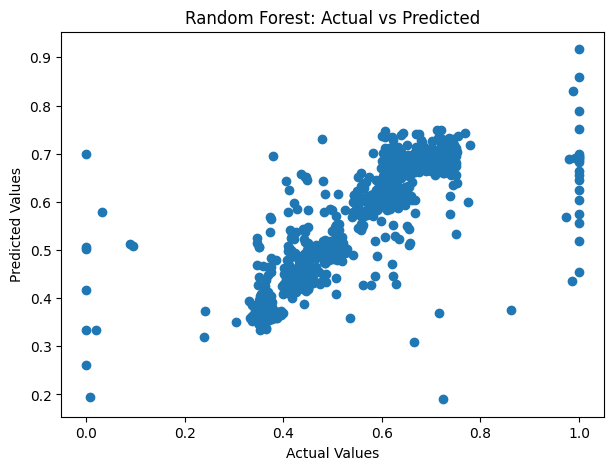

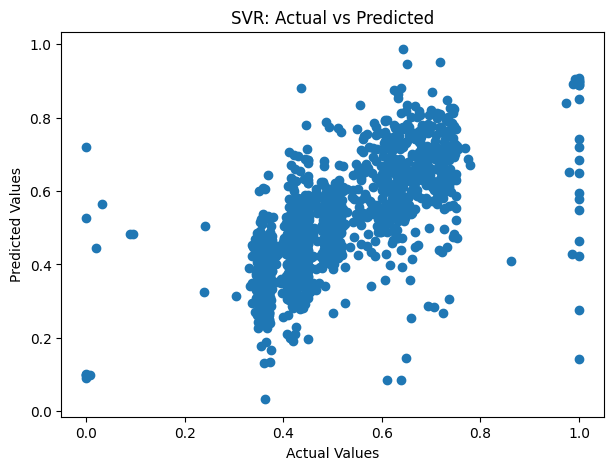

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Load dataset
df = pd.read_csv(r"C:\Users\CTrader\Desktop\3 rd year\CI\DP\DataPreprocessing\smartshine_carwash_processed_data.csv")

# Features used
features = [
    'vehicle_type_encoded',
    'service_type_encoded',
    'day_of_week_encoded',
    'location_encoded',
    'payment_method_encoded',
    'service_duration',
    'customer_rating',
    'visit_frequency',
    'total_spent',
    'avg_spent_per_visit',
    'avg_rating',
    'days_since_last_visit',
]

target = 'service_cost'  
# OR replace with:
# target = 'days_since_last_visit'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# MODEL 1: RANDOM FOREST
# -------------------------
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Random Forest metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)


# -------------------------
# MODEL 2: SUPPORT VECTOR REGRESSION (SVR)
# -------------------------
svr = SVR(kernel='rbf', C=100, gamma=0.1)
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

# SVR metrics
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_rmse = math.sqrt(mean_squared_error(y_test, svr_pred))

print("SVR MAE:", svr_mae)
print("SVR RMSE:", svr_rmse)


# -------------------------
# PLOT 1 — Random Forest vs Actual
# -------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

# -------------------------
# PLOT 2 — SVR vs Actual
# -------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_test, svr_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR: Actual vs Predicted")
plt.show()
